In [1]:
import networkx as nx
import numpy as np
import utils
from causality.pc.CausalGraphBuilder import CausalGraphBuilder
from causality.pc.EdgeOrientation import EdgeOrientation
from causality.pc.independence.GaussIndependenceTest import GaussConditionalIndepTest
from causality.pc.pag.PagDrawer import PagDrawer
from causality.pc.pag.PagEdge import PagEdge
from IPython.display import Image

# Examples of usage
### Initialization of builders

In [2]:
# when we observe every needed variables (Causal Sufficiency is satisfied)
pc_builder = CausalGraphBuilder('pc', p_value=0.01)

# when there are hidden variables affecting at least two others (Causal Sufficiency isn't satisfied)
fci_builder = CausalGraphBuilder('fci', p_value=0.01)

# faster version of FCI, but it can't extract separation sets in current implementation in pcalg
fciPlus_builder = CausalGraphBuilder('fci+', p_value=0.01)

### Loading data

You probably will have to do it in other way, but you should obtain matrix __(n_samples, n_variables)__.
I will show examples with reduced amount of variables, so the work would be faster and graphs would be representable.

In [3]:
short_metrics_p, long_metrics_p = utils.read_data(dataset_name='feed_top_ab_tests_pool_big_dataset.csv', shift=True)
short_metrics = short_metrics_p[:, :10, 0]
long_metrics = long_metrics_p[:, :2, 0]

metrics = np.hstack((long_metrics, short_metrics))
n_samples, n_metrics = metrics.shape

n_short_metrics = short_metrics.shape[1]
n_long_metrics = long_metrics.shape[1]

### Setting labels and colors

In [4]:
labels = []
colors = []
for i in range(n_long_metrics):
    labels.append('long_' + str(i))
    colors.append('red')
for i in range(n_short_metrics):
    labels.append('short_' + str(i))
    colors.append('green')

### Example of inference with PC algorithm

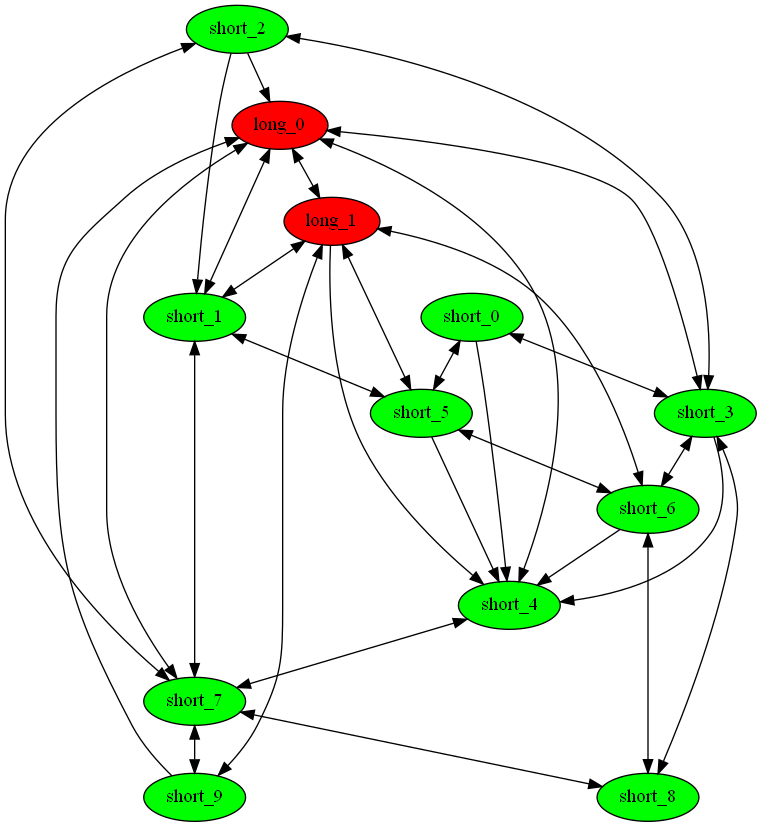

In [5]:
pc_builder.fit(metrics)
pag_edges = pc_builder.get_edges()
Image(PagDrawer.draw(pag_edges, n_metrics, colors=colors, labels=labels))

### Example of inference with FCI algorithm

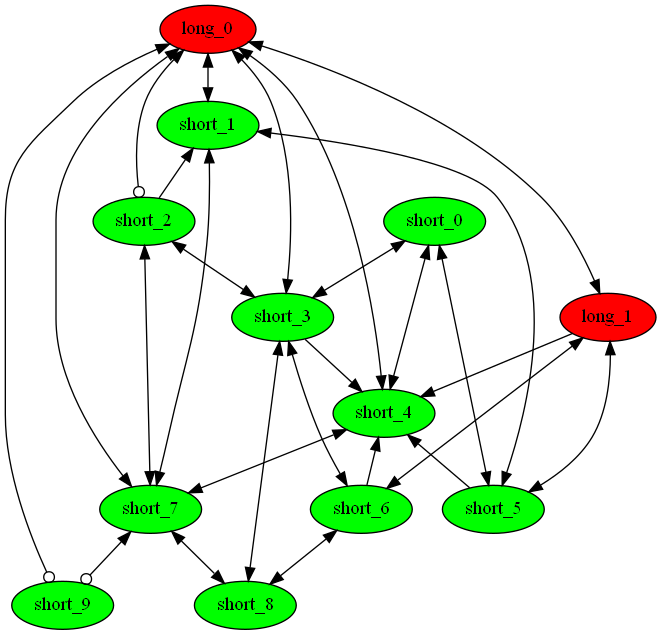

In [6]:
fci_builder.fit(metrics)
pag_edges = fci_builder.get_edges()
Image(PagDrawer.draw(pag_edges, n_metrics, colors=colors, labels=labels))

### Example of custom edge orientation

In [7]:
pc_builder.fit(metrics)
pag_edges = pc_builder.get_edges()
skeleton = nx.from_edgelist(list(map(PagEdge.to_regular_edge, pag_edges)))

indep_test_func = GaussConditionalIndepTest(np.corrcoef(metrics.T), sample_size=n_samples).gauss_ci_test
edge_orienter = EdgeOrientation(skeleton=skeleton,
                                sep_sets=pc_builder.get_sepsets(),
                                n_nodes=n_metrics,
                                indep_test_func=indep_test_func,
                                threshold=5e-1) # this threshold could vary

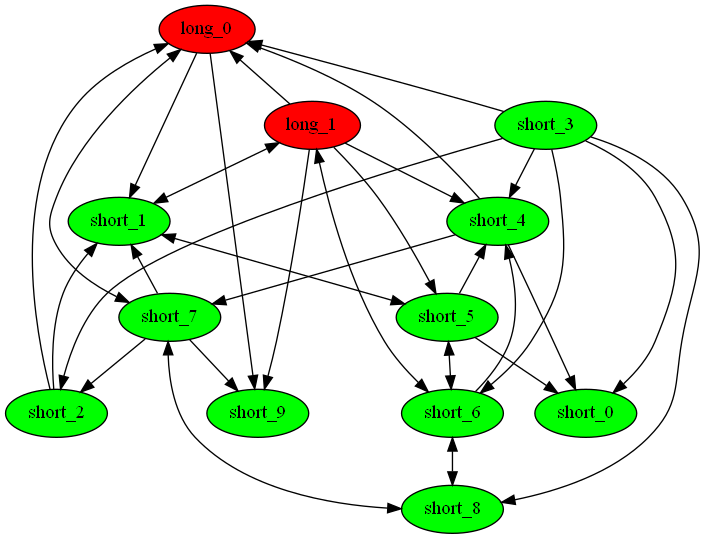

In [8]:
edge_orienter.orient_colliders()
edge_orienter.apply_rules(pc=True)
pag_edges = edge_orienter.get_pag()
Image(PagDrawer.draw(pag_edges, n_metrics, labels=labels, colors=colors))
